In [1]:
# Import necessary libraries
import pyreadr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
import plotly.graph_objects as go
import numpy as np
import streamlit as st
from pycirclize import Circos
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li
import scanpy as sc
from anndata import AnnData
import pandas as pd
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the PVAT data (Exported data from original Anndata)
pvat_lliana = sc.read_h5ad('../data/exported_data/pvat_adata.h5ad')  # actual data + added nichenet cellchat and cellphonedb results which can be added to adata.uns from csv
pvat_lliana

AnnData object with n_obs × n_vars = 29703 × 14522
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', '_scvi_batch', '_scvi_labels', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.5', 'leiden0.8', 'leiden1.0', 'leiden1.2', 'leiden1.5', 'leiden', 'female_epithelial', 'adipocyte', 'male_epithelial', 'dendritic_cell', 'macrophage', 'ASPC', 'monocyte', 'endothelial', 'SMC', 'nk_cell', 'LEC', 'pericyte', 't_cell', 'b_cell', 'mast_cell', 'neutrophil', 'mesothelium', 'endometrium', 'CD4+ T-cells', 'Adipocytes', 'Macrophages', 'Fibroblasts/Preadipocytes', 'Fibroblasts/Chondrocytes', 'Endothelial cells', 'B-cells', 'Skeletal m

In [3]:
# Define paths to interaction data for cellchat and cellphonedb
cellchat_data = "../data/analysis_results/pvat_cci_using_cellchat.csv"
cellphonedb_data = "../data/analysis_results/pvat_cci_using_cellphonedb.csv"

## Nichenet Dotplot

In [17]:
# Load RDS file using rpy2, needed for interaction data

filepath = '../data/analysis_results/pvat_cci_autocrine_included.rds'
readRDS = ro.r['readRDS']
pvat_cci = readRDS(filepath)

In [18]:
# Extract interactions from the RDS data, filter by ligand and receptor specificities

source_labels = ["Adipocytes", "Adipocytes_2", "ASPC", "Endothelial cells",
                "Immune cells", "Mesothelium",
                "Neuronal-like cells", "SMCs & Pericytes"]

target_labels = ["Adipocytes", "Adipocytes_2", "ASPC", "Endothelial cells",
                "Immune cells", "Mesothelium",
                "Neuronal-like cells", "SMCs & Pericytes"]

cell_pair_interactions = []

for source_cell in source_labels:
    for target_cell in target_labels:
            cell_pair_string = f'{source_cell.replace(" ", "")}2{target_cell.replace(" ", "")}'
            cell_one2cell_two = pvat_cci.rx2(cell_pair_string)
            ligand_receptor = pandas2ri.rpy2py(cell_one2cell_two.rx2('p_ligand_receptor_network'))
            long_format = ligand_receptor.T.stack().reset_index().set_axis('ligand_complex receptor_complex weight'.split(), axis=1)
            long_format['source'] = source_cell
            long_format['target'] = target_cell
        
            cell_pair_interactions.append(long_format)

nichenet_cci = pd.concat(cell_pair_interactions)

In [19]:
# Filter for ligands containing 'Col' and receptors containing 'Itg', then by specific cell types

nichenet_ligand_receptor_string = (nichenet_cci.loc[:,'ligand_complex'].str.contains('Col')) & (nichenet_cci.loc[:,'receptor_complex'].str.contains('Itg'))
nichenet_col = nichenet_cci[nichenet_ligand_receptor_string]

source_labels = ["Adipocytes", "ASPC", "SMCs & Pericytes"]
target_labels = ["Adipocytes", "ASPC", "SMCs & Pericytes"]

nichenet_col = nichenet_col[
    (nichenet_col['source'].isin(source_labels)) & 
    (nichenet_col['target'].isin(target_labels))
]

#nichenet_col.to_csv("nichenet_supplemental_interactions.csv")

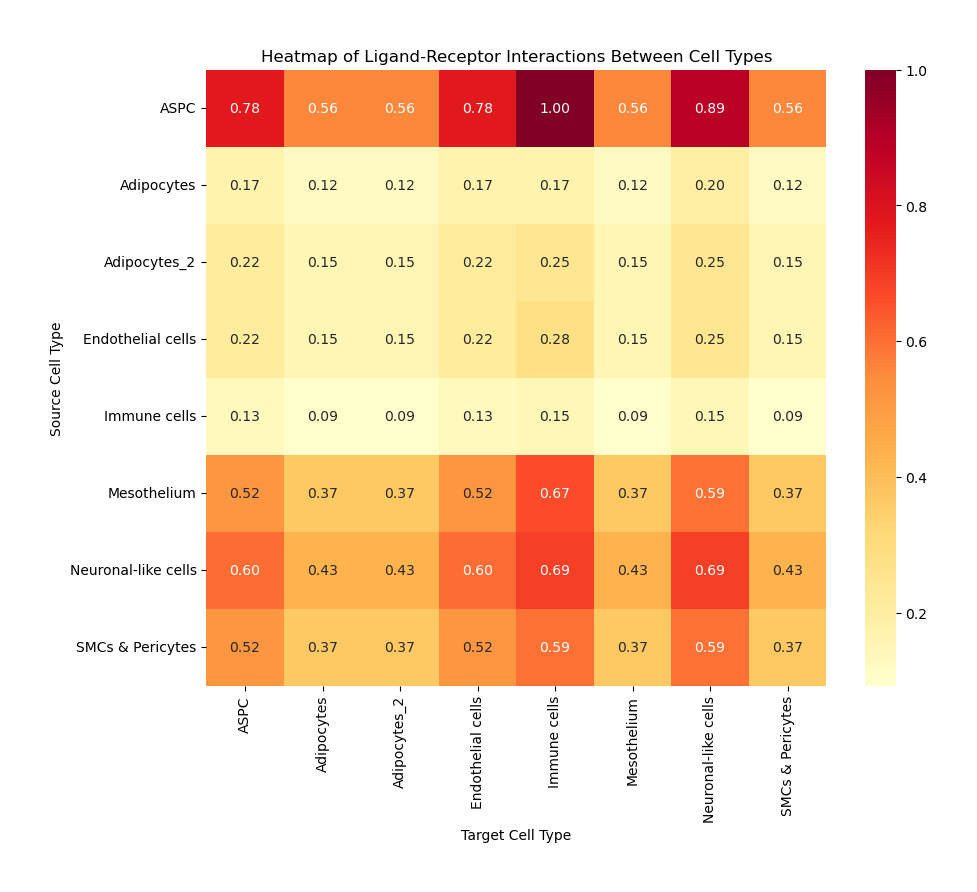

In [20]:
# Heatmap visualization of cell types interactions 

expanded_df = pd.DataFrame(nichenet_cci[nichenet_ligand_receptor_string])


interaction_pivot_table = expanded_df.groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_nichenet = interaction_pivot_table / interaction_pivot_table.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_nichenet, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

#fig.savefig('Nichenet_Heatmap.pdf')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


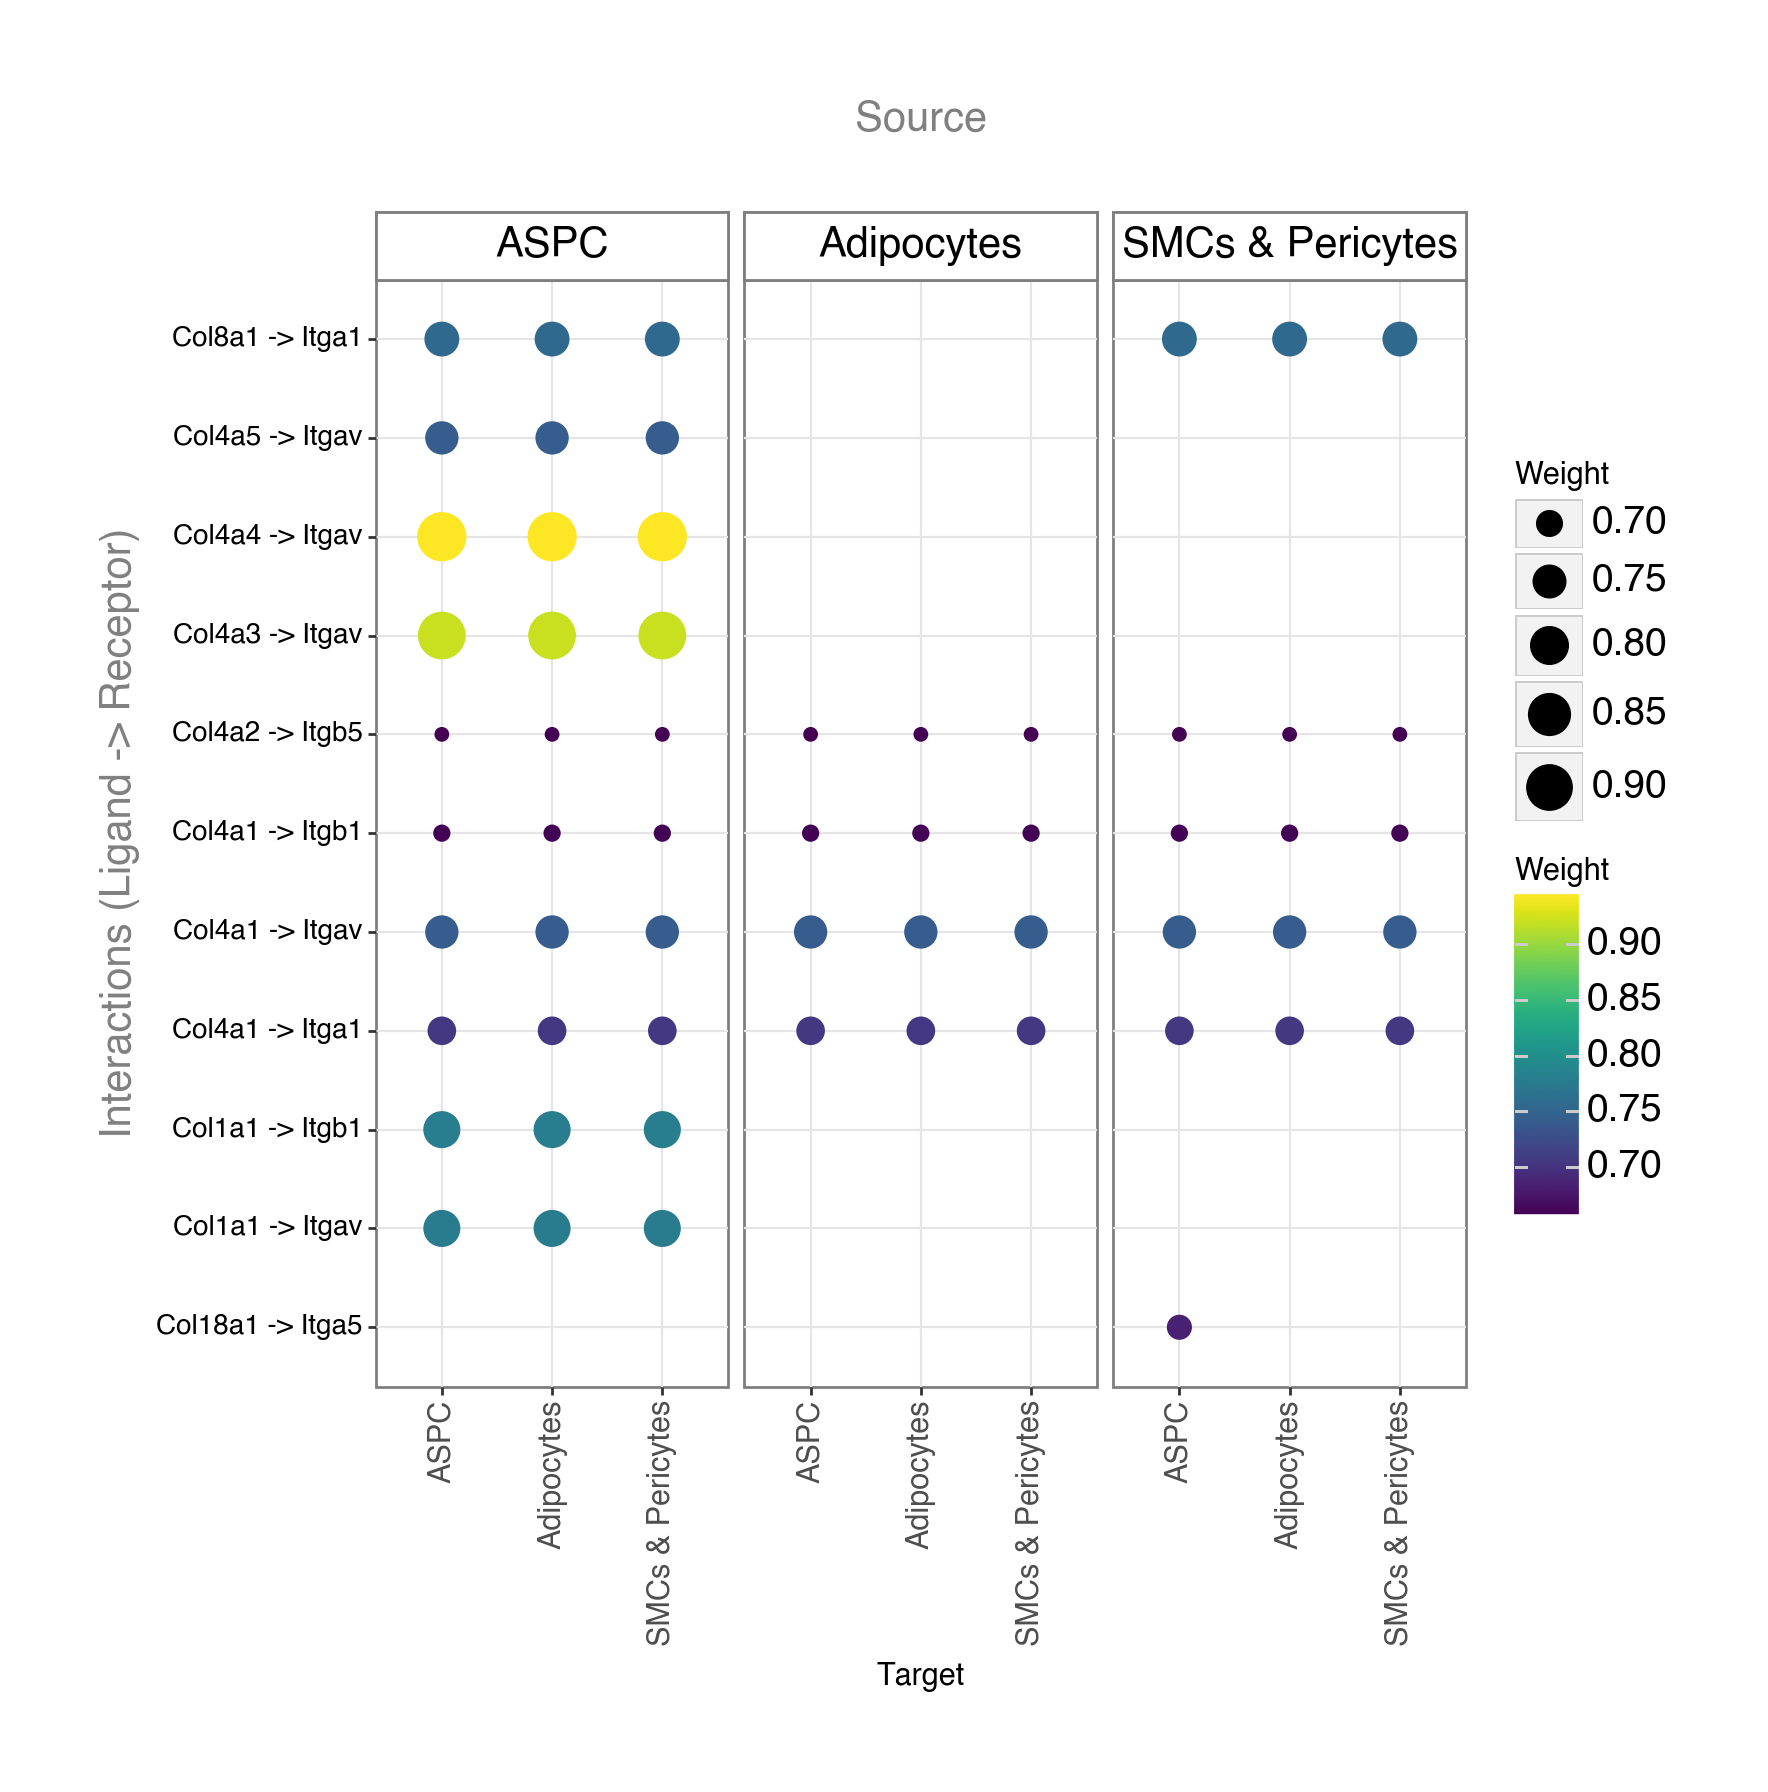

<Figure Size: (800 x 800)>

In [22]:
# A workaround for nichenet in lliana so that it consistent with the other 2 plots(cellphonedb and cellchat)
pvat_lliana.uns['nichenet_res'] = nichenet_col[nichenet_col['weight']>=0.6]
nichenet_plot = li.pl.dotplot(adata = pvat_lliana,
              colour='weight',
              size='weight',
              source_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              target_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              figure_size=(8, 8),
              uns_key='nichenet_res' # uns_key to use, default is 'liana_res'
             )
nichenet_plot
#nichenet_plot.save("nichenet_dotplot.pdf")

## CellChat Plots

In [24]:
cellchat = pd.read_csv(cellchat_data, index_col=0)
cellchat.head()

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
2424,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.978139,0.537985,Mesothelium,Adipocytes,0.250632,0.0
6408,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.919949,0.495399,Mesothelium,Immune cells,0.235464,0.0
1839,App,App,0.763441,0.278940,7.355702,Lrp6,Lrp6,0.978139,0.537985,ASPC,Adipocytes,0.230846,0.0
4939,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.878685,0.478230,Mesothelium,Endothelial cells,0.229174,0.0
10867,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.872581,0.472723,Mesothelium,SMCs & Pericytes,0.227134,0.0


In [26]:
cellchat_ligand_receptor_string = (cellchat.loc[:,'ligand_complex'].str.contains('Col')) & (cellchat.loc[:,'receptor_complex'].str.contains('Itg'))
cellchat_pvals = cellchat.loc[:,'cellchat_pvals'] <= 0.05
pvat_lliana.uns['cellchat_res_temp'] = cellchat[cellchat_ligand_receptor_string & cellchat_pvals]

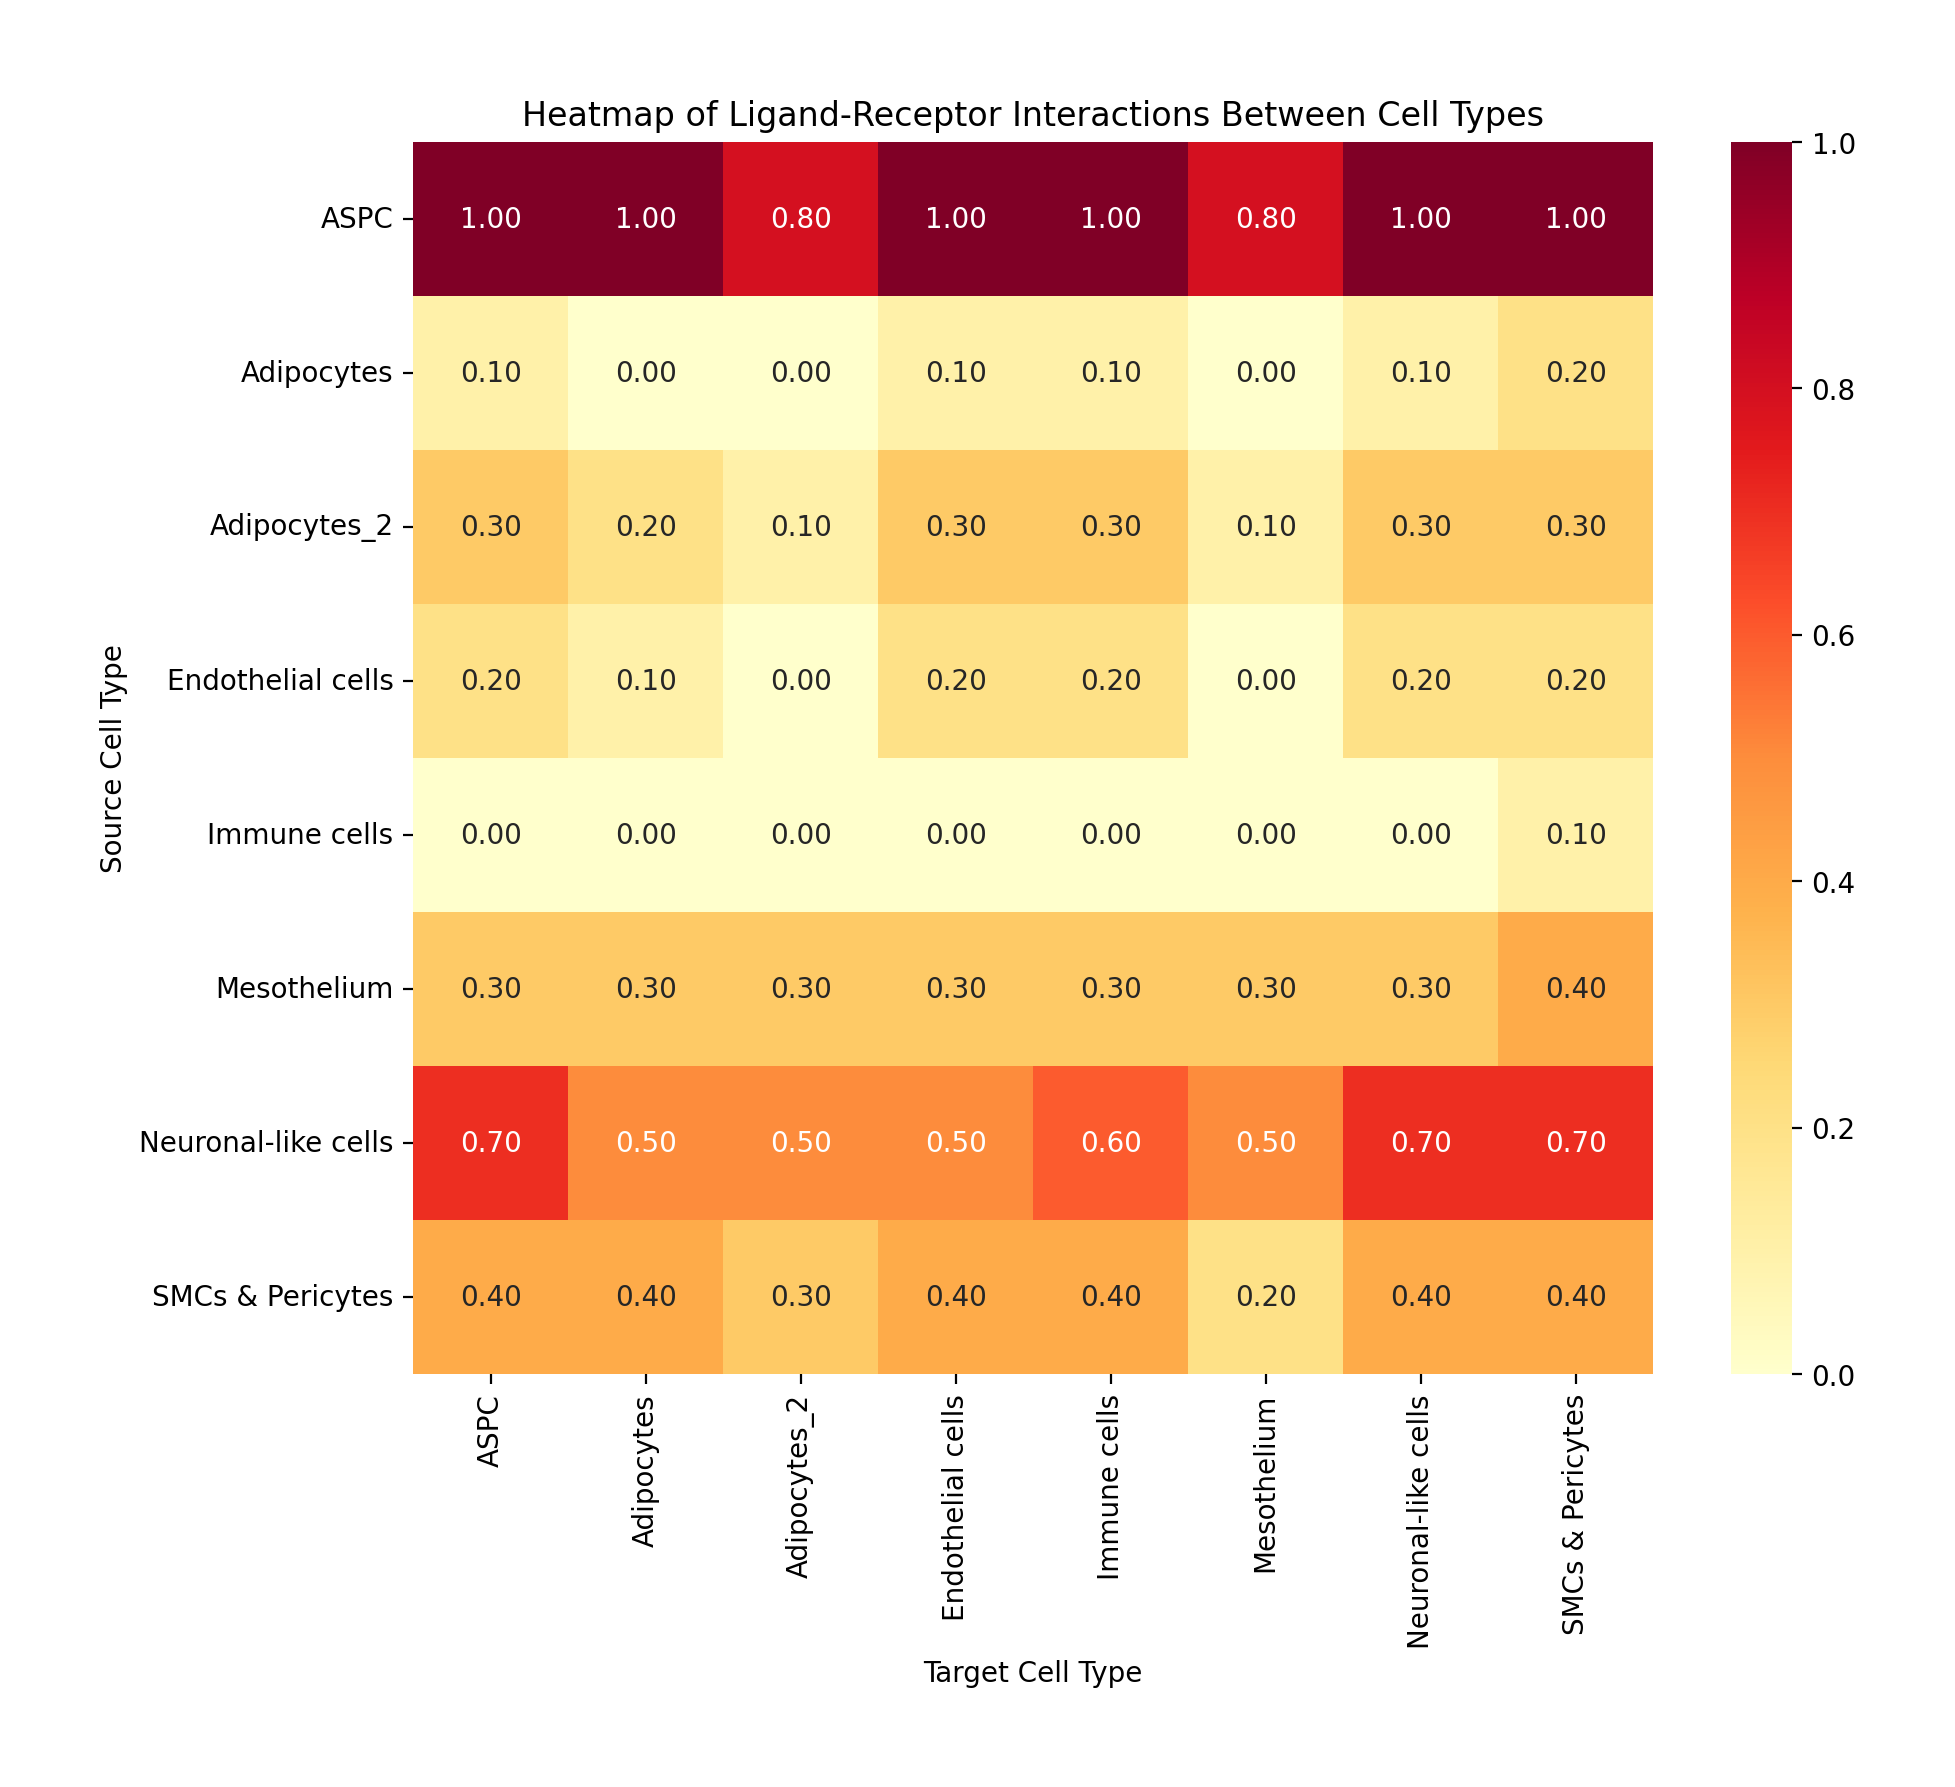

In [27]:
expanded_df = pd.DataFrame(pvat_lliana.uns['cellchat_res_temp'])


interaction_pivot_table = expanded_df.groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellchat = interaction_pivot_table / interaction_pivot_table.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellchat, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()
#fig.savefig('Cellchat_Heatmap.pdf')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


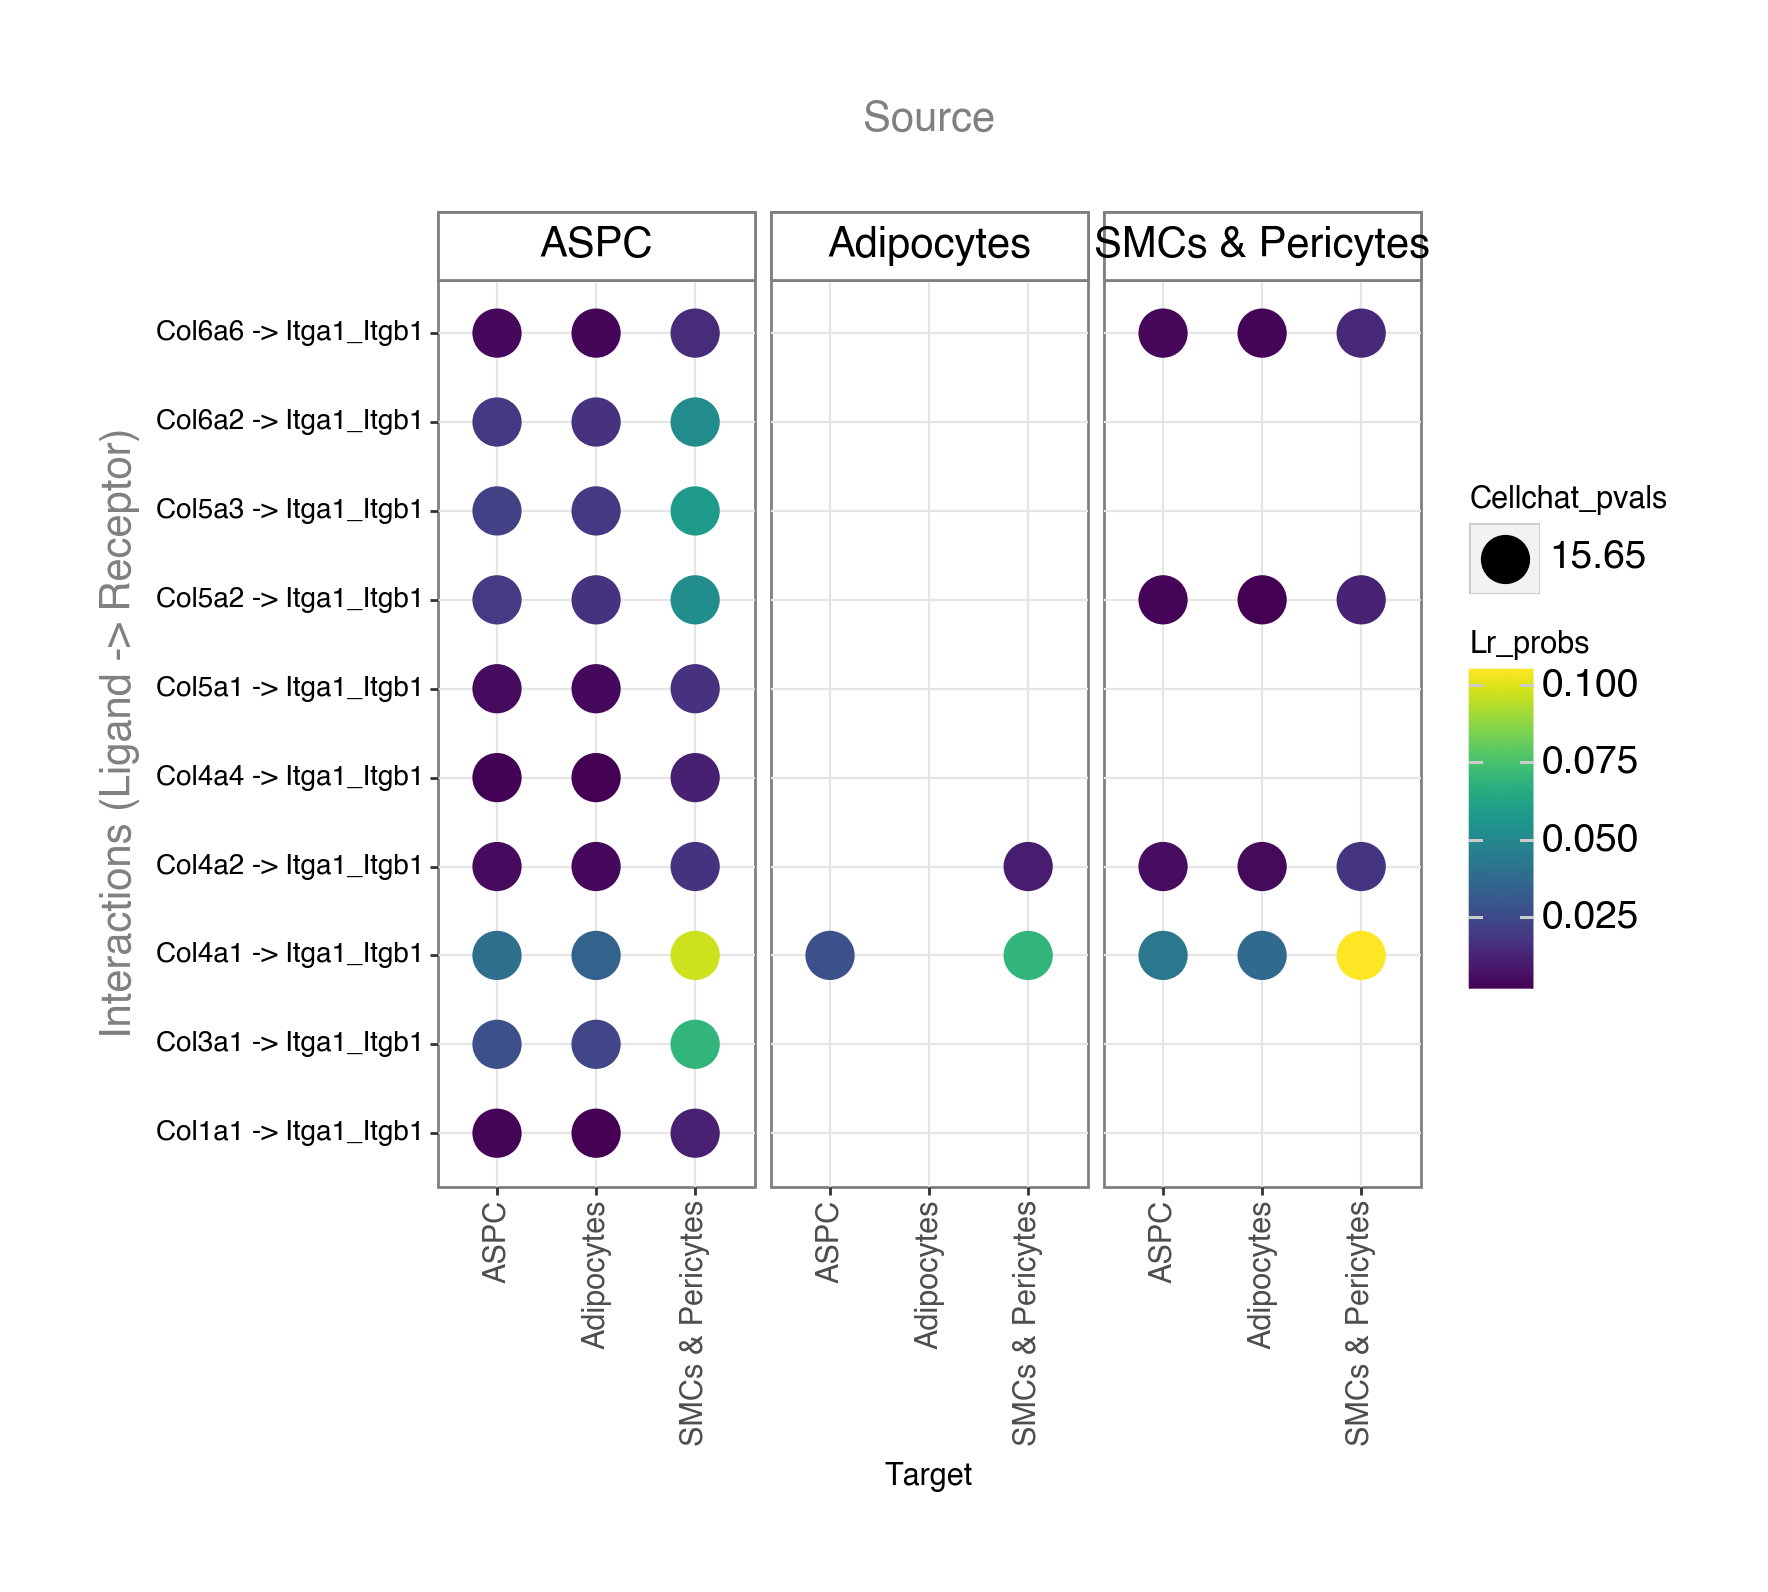

<Figure Size: (800 x 700)>

In [29]:
cellchat_plot = li.pl.dotplot(adata = pvat_lliana,
              colour='lr_probs',
              size='cellchat_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              target_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              figure_size=(8, 7),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellchat_pvals'] <= 0.05,
              uns_key='cellchat_res_temp' # uns_key to use, default is 'liana_res'
             )
cellchat_plot
#cellchat_plot.save("cellchat_dotplot.pdf")

In [31]:
# for supplementals
cellchat_ligand_receptor_string = (cellchat.loc[:,'ligand_complex'].str.contains('Col')) & (cellchat.loc[:,'receptor_complex'].str.contains('Itg'))
cellchat_source_string = cellchat.loc[:,'source'].isin(["Adipocytes", "ASPC", "SMCs & Pericytes"])
cellchat_target_string = cellchat.loc[:,'target'].isin(["Adipocytes", "ASPC", "SMCs & Pericytes"])
cellchat_pvals = cellchat.loc[:,'cellchat_pvals'] <= 0.05
cellchat_col = cellchat[cellchat_ligand_receptor_string & cellchat_source_string & cellchat_target_string & cellchat_pvals]
cellchat_col.head()
#cellchat_col.to_csv("cellchat_supplemental_interactions.csv")

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
11200,Col4a1,Col4a1,0.851613,0.359760,7.355702,Itgb1,Itga1_Itgb1,0.540323,0.158821,SMCs & Pericytes,SMCs & Pericytes,0.102555,0.0
10125,Col4a1,Col4a1,0.762097,0.331430,7.355702,Itgb1,Itga1_Itgb1,0.540323,0.158821,ASPC,SMCs & Pericytes,0.095249,0.0
10171,Col3a1,Col3a1,0.717742,0.232539,7.355702,Itgb1,Itga1_Itgb1,0.540323,0.158821,ASPC,SMCs & Pericytes,0.068783,0.0
10329,Col4a1,Col4a1,0.653029,0.232034,7.355702,Itgb1,Itga1_Itgb1,0.540323,0.158821,Adipocytes,SMCs & Pericytes,0.068644,0.0
10165,Col5a3,Col5a3,0.559140,0.193216,7.355702,Itgb1,Itga1_Itgb1,0.540323,0.158821,ASPC,SMCs & Pericytes,0.057825,0.0


## CellPhoneDB Plots

In [33]:
cellphonedb = pd.read_csv(cellphonedb_data, index_col=0)
cellphonedb.head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
2424,App,App,2.094847,0.847328,Lrp6,Lrp6,3.826881,0.978139,Mesothelium,Adipocytes,2.960864,0.0
1839,App,App,1.827846,0.763441,Lrp6,Lrp6,3.826881,0.978139,ASPC,Adipocytes,2.827364,0.0
2599,App,App,1.778637,0.736434,Lrp6,Lrp6,3.826881,0.978139,Neuronal-like cells,Adipocytes,2.802759,0.0
2763,App,App,1.738830,0.732258,Lrp6,Lrp6,3.826881,0.978139,SMCs & Pericytes,Adipocytes,2.782855,0.0
6407,App,App,2.094847,0.847328,Lrp6,Lrp6,3.359254,0.919949,Mesothelium,Immune cells,2.727050,0.0


In [34]:
cellphonedb_ligand_receptor_string = (cellphonedb.loc[:,'ligand_complex'].str.contains('Col')) & (cellphonedb.loc[:,'receptor_complex'].str.contains('Itg'))
cellphonedb_pvals = cellphonedb.loc[:,'cellphone_pvals'] <= 0.05
pvat_lliana.uns['cpdb_res_temp'] = cellphonedb[cellphonedb_ligand_receptor_string & cellphonedb_pvals]

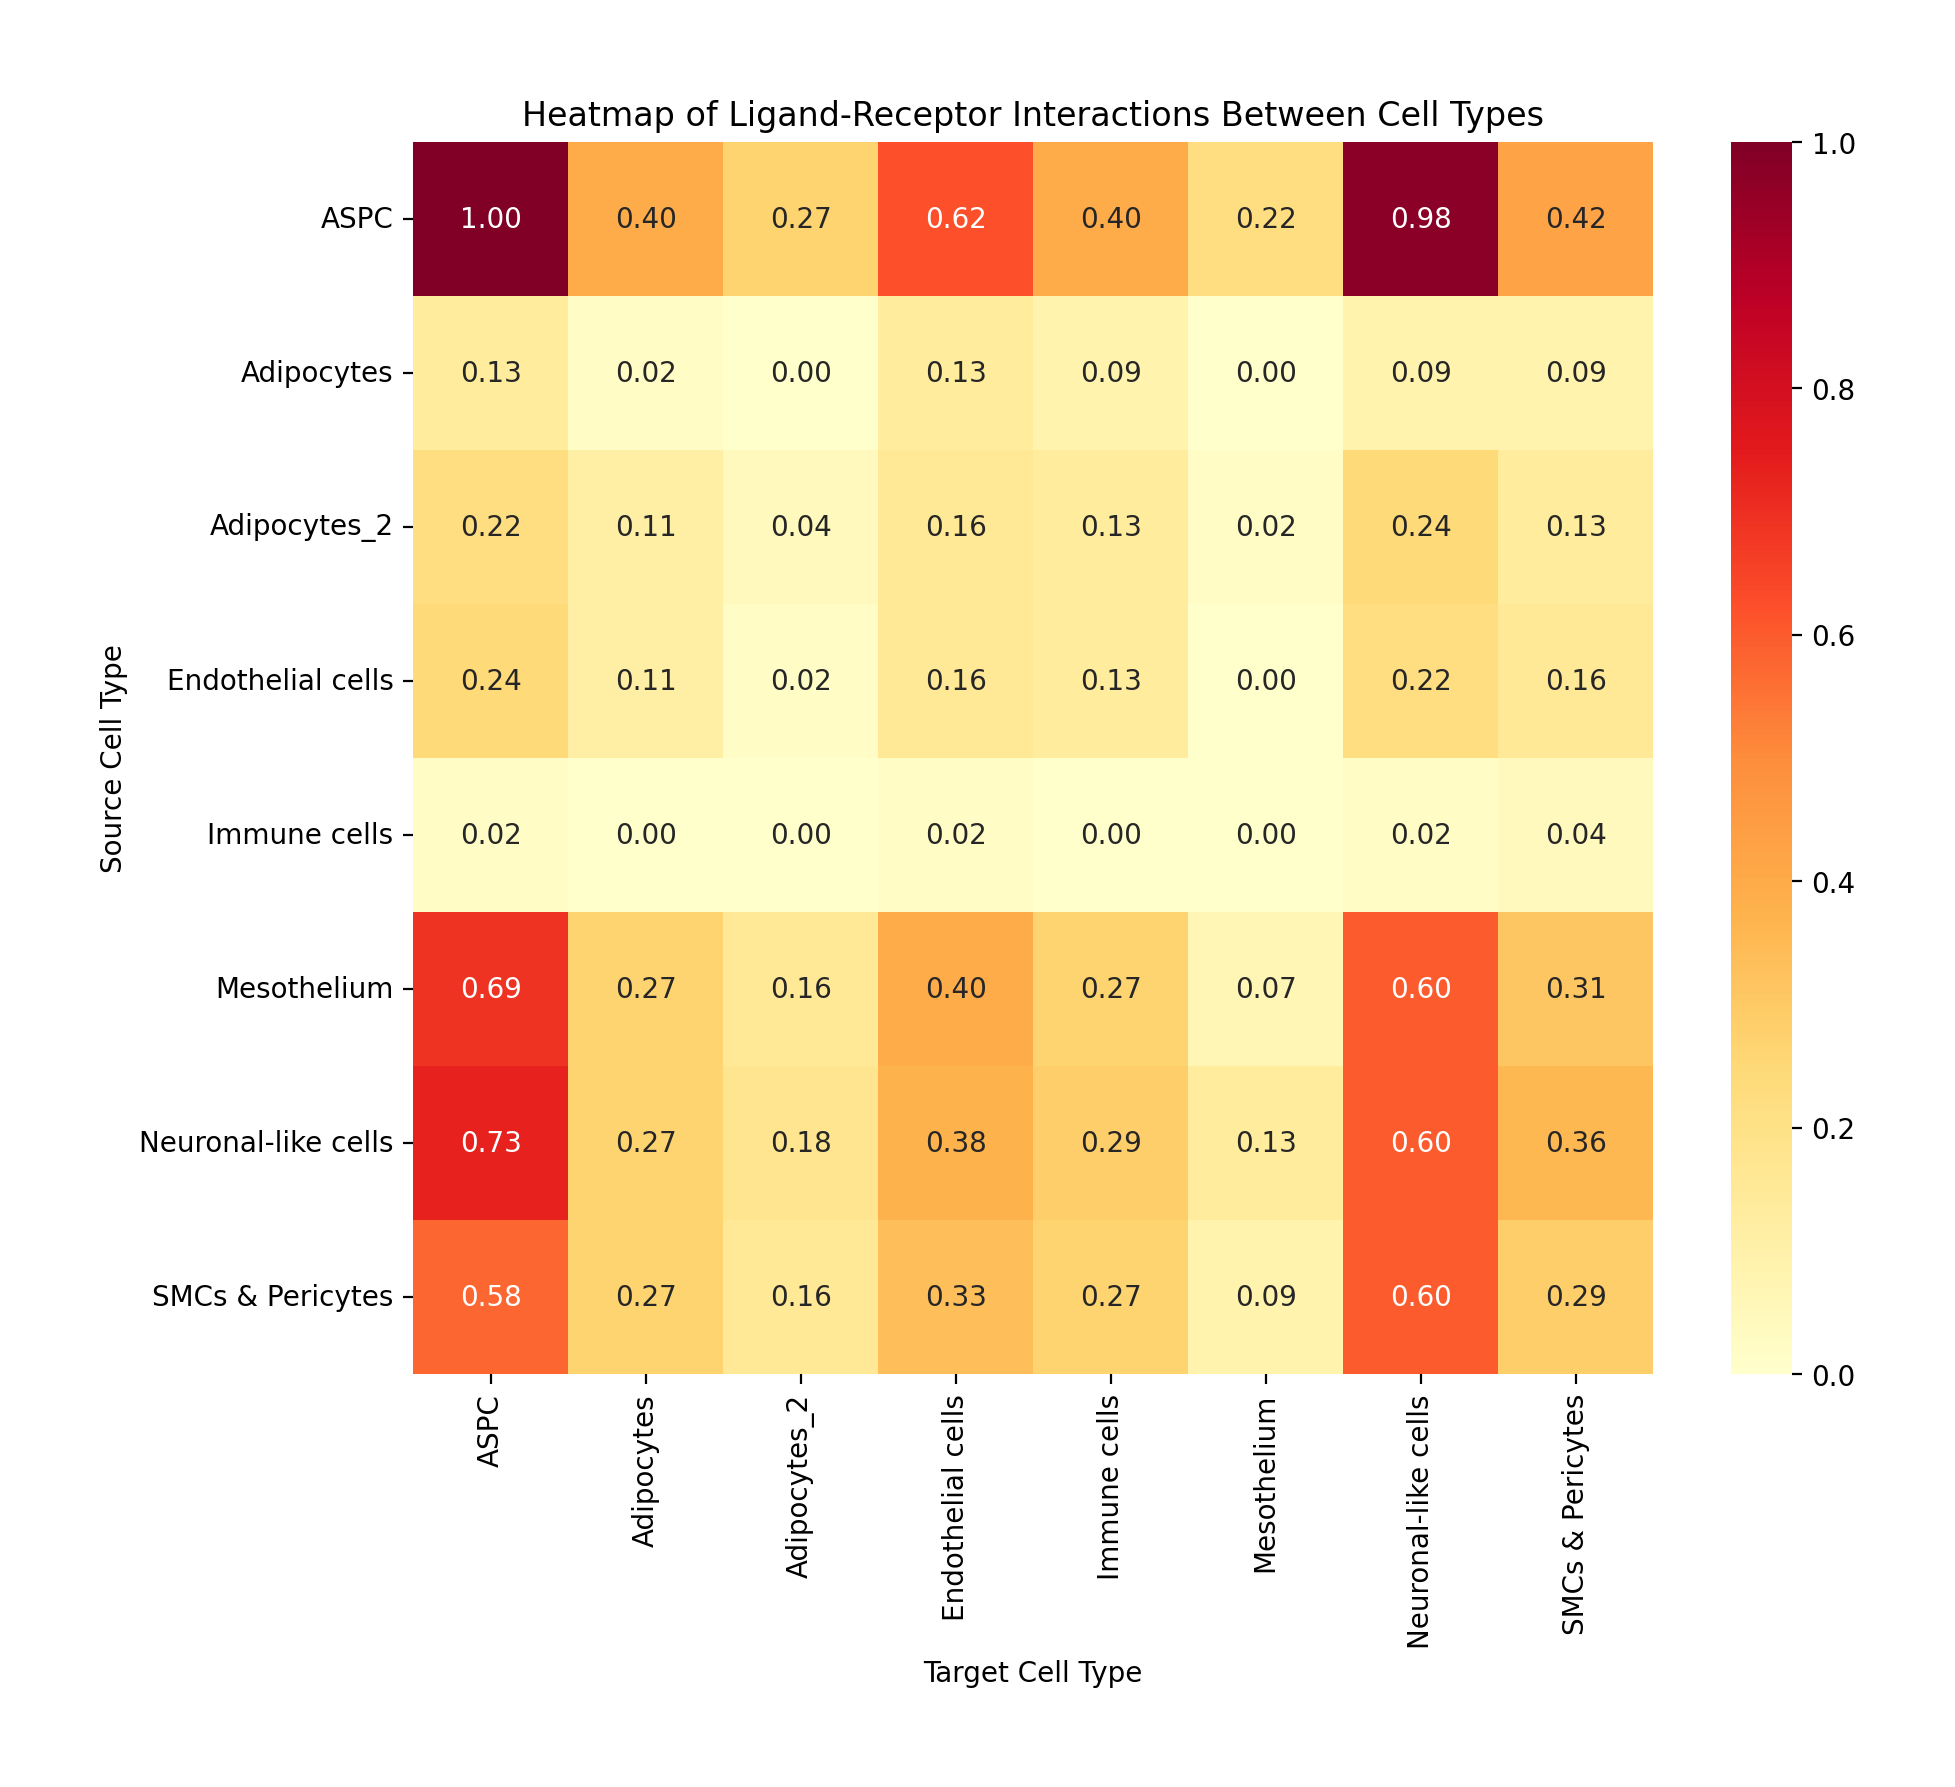

In [35]:
expanded_df = pd.DataFrame(pvat_lliana.uns['cpdb_res_temp'])


interaction_pivot_table = expanded_df.groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellphonedb = interaction_pivot_table / interaction_pivot_table.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellphonedb, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()
#fig.savefig('Cellphonedb_Heatmap.pdf')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


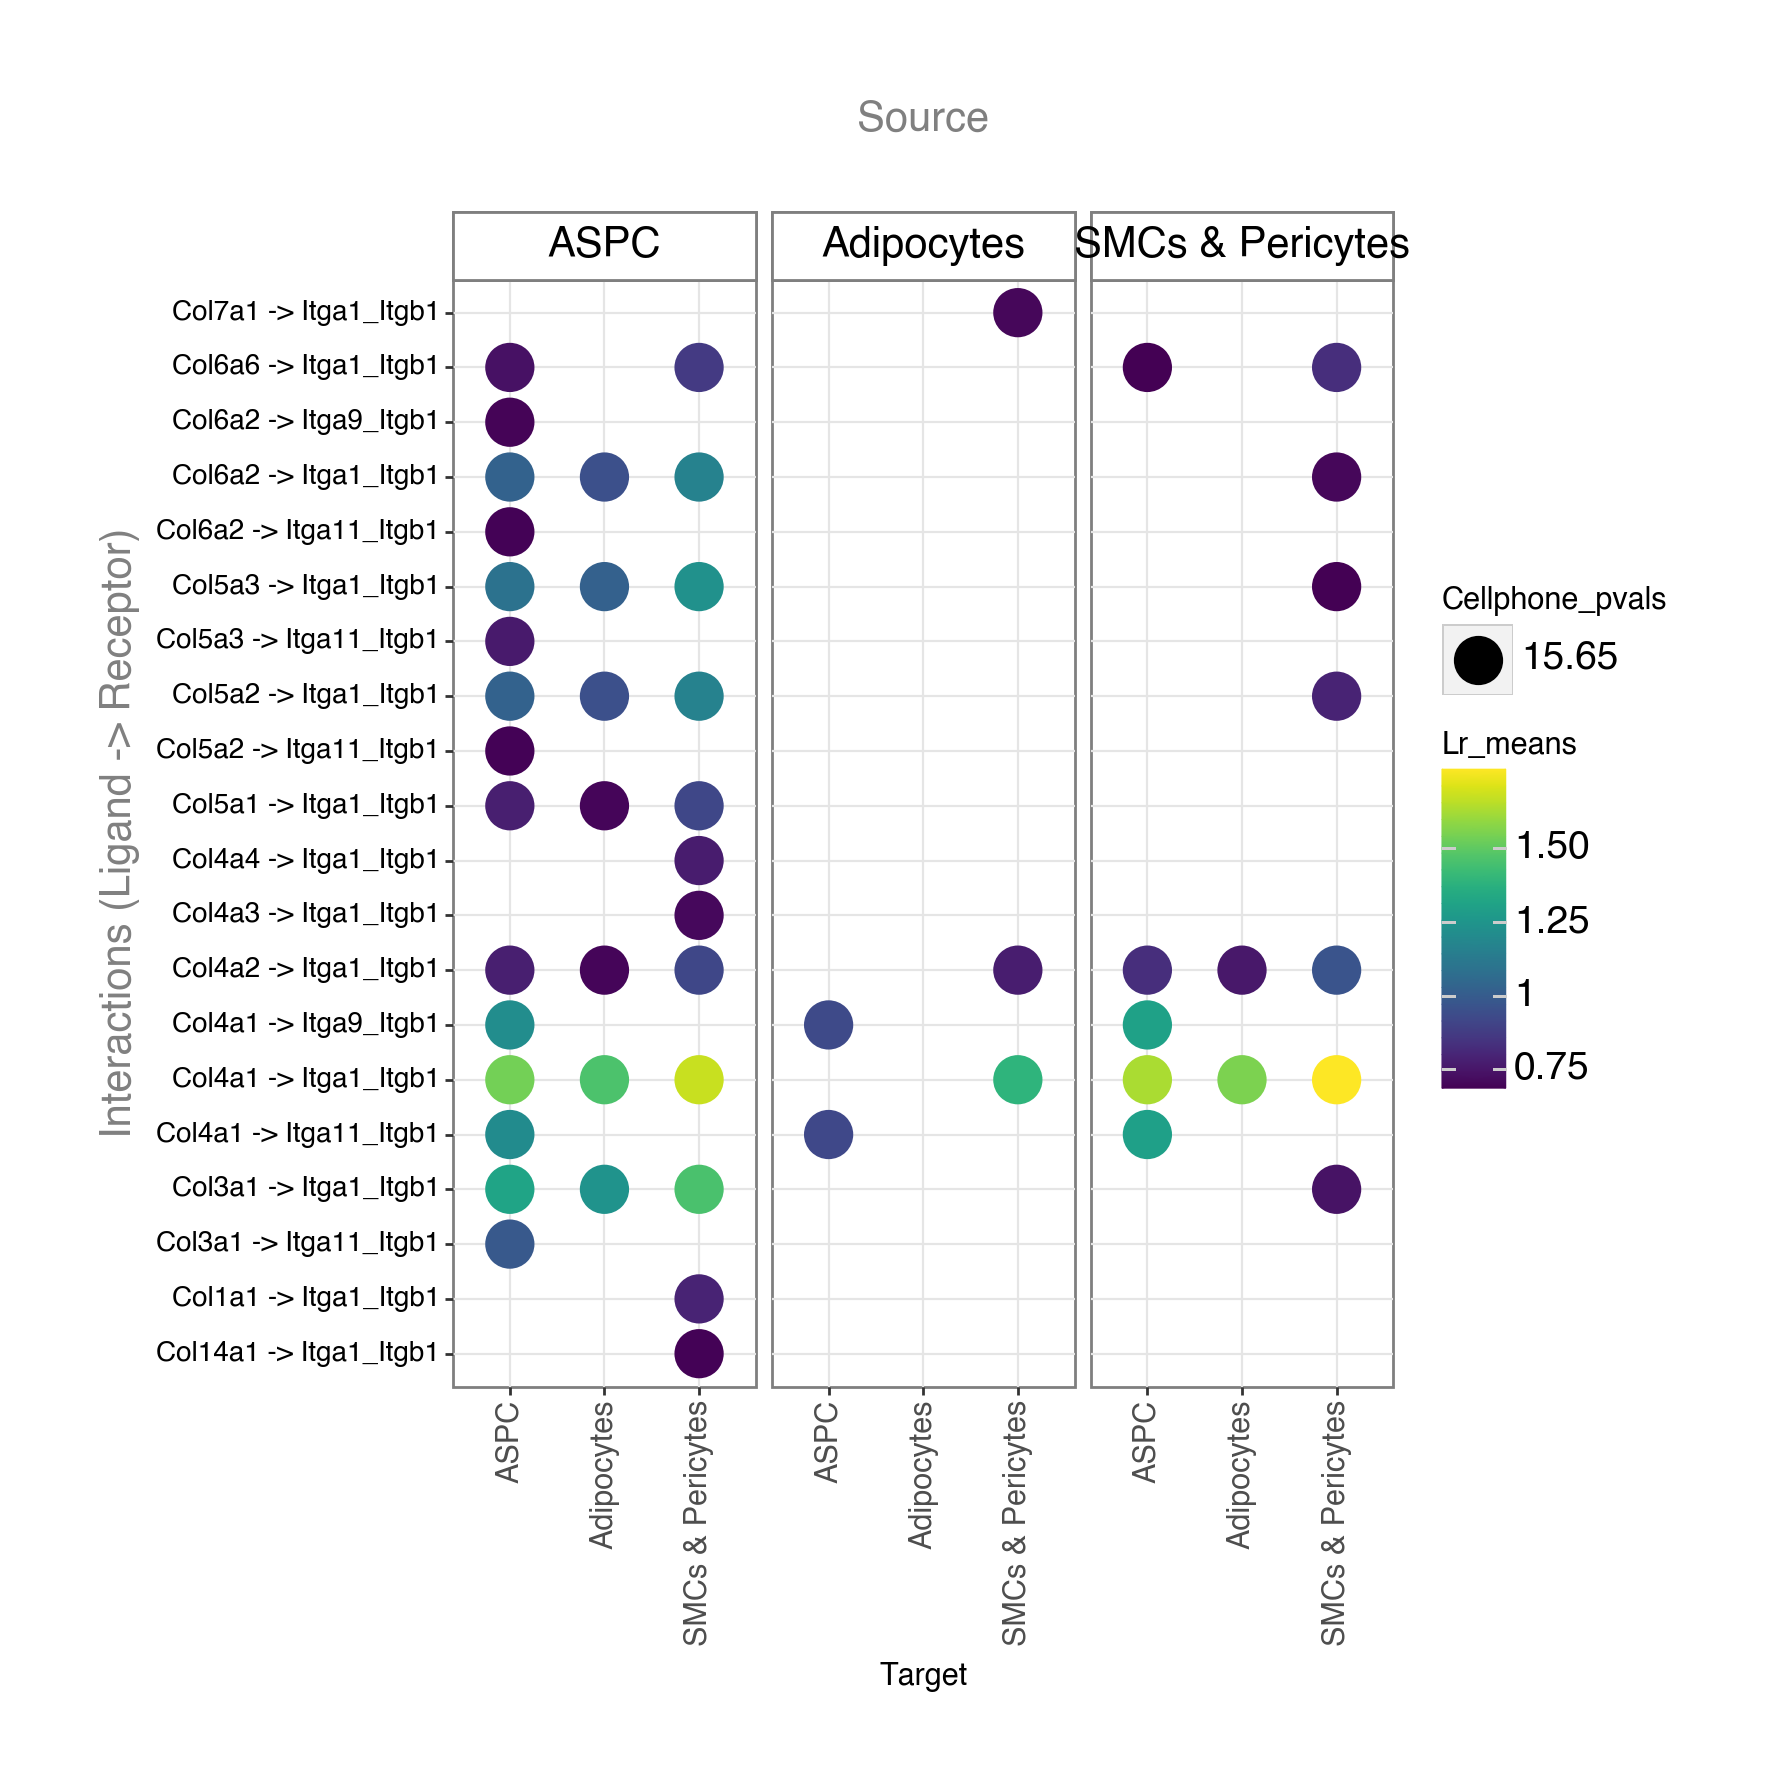

<Figure Size: (800 x 800)>

In [36]:
cellphonedb_lrmeans = cellphonedb.loc[:,'lr_means'] >=0.7
pvat_lliana.uns['cpdb_res_temp'] = cellphonedb[cellphonedb_ligand_receptor_string & cellphonedb_pvals & cellphonedb_lrmeans]

li.pl.dotplot(adata = pvat_lliana,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              target_labels=['Adipocytes', 'ASPC', 'SMCs & Pericytes'],
              figure_size=(8, 8),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
              uns_key='cpdb_res_temp' # uns_key to use, default is 'liana_res'
             )

In [ ]:
cellphonedb_source_string = cellphonedb.loc[:,'source'].isin(["Adipocytes", "ASPC", "SMCs & Pericytes"])
cellphonedb_target_string = cellphonedb.loc[:,'target'].isin(["Adipocytes", "ASPC", "SMCs & Pericytes"])
cellphonedb_col = cellphonedb[cellphonedb_ligand_receptor_string & cellphonedb_source_string & cellphonedb_target_string & cellphonedb_pvals]
#cellphonedb_col.to_csv("cellphonedb_supplemental_interactions.csv")

In [ ]:
#cellphonedb_plot.save("cellphonedb_dotplot.pdf")

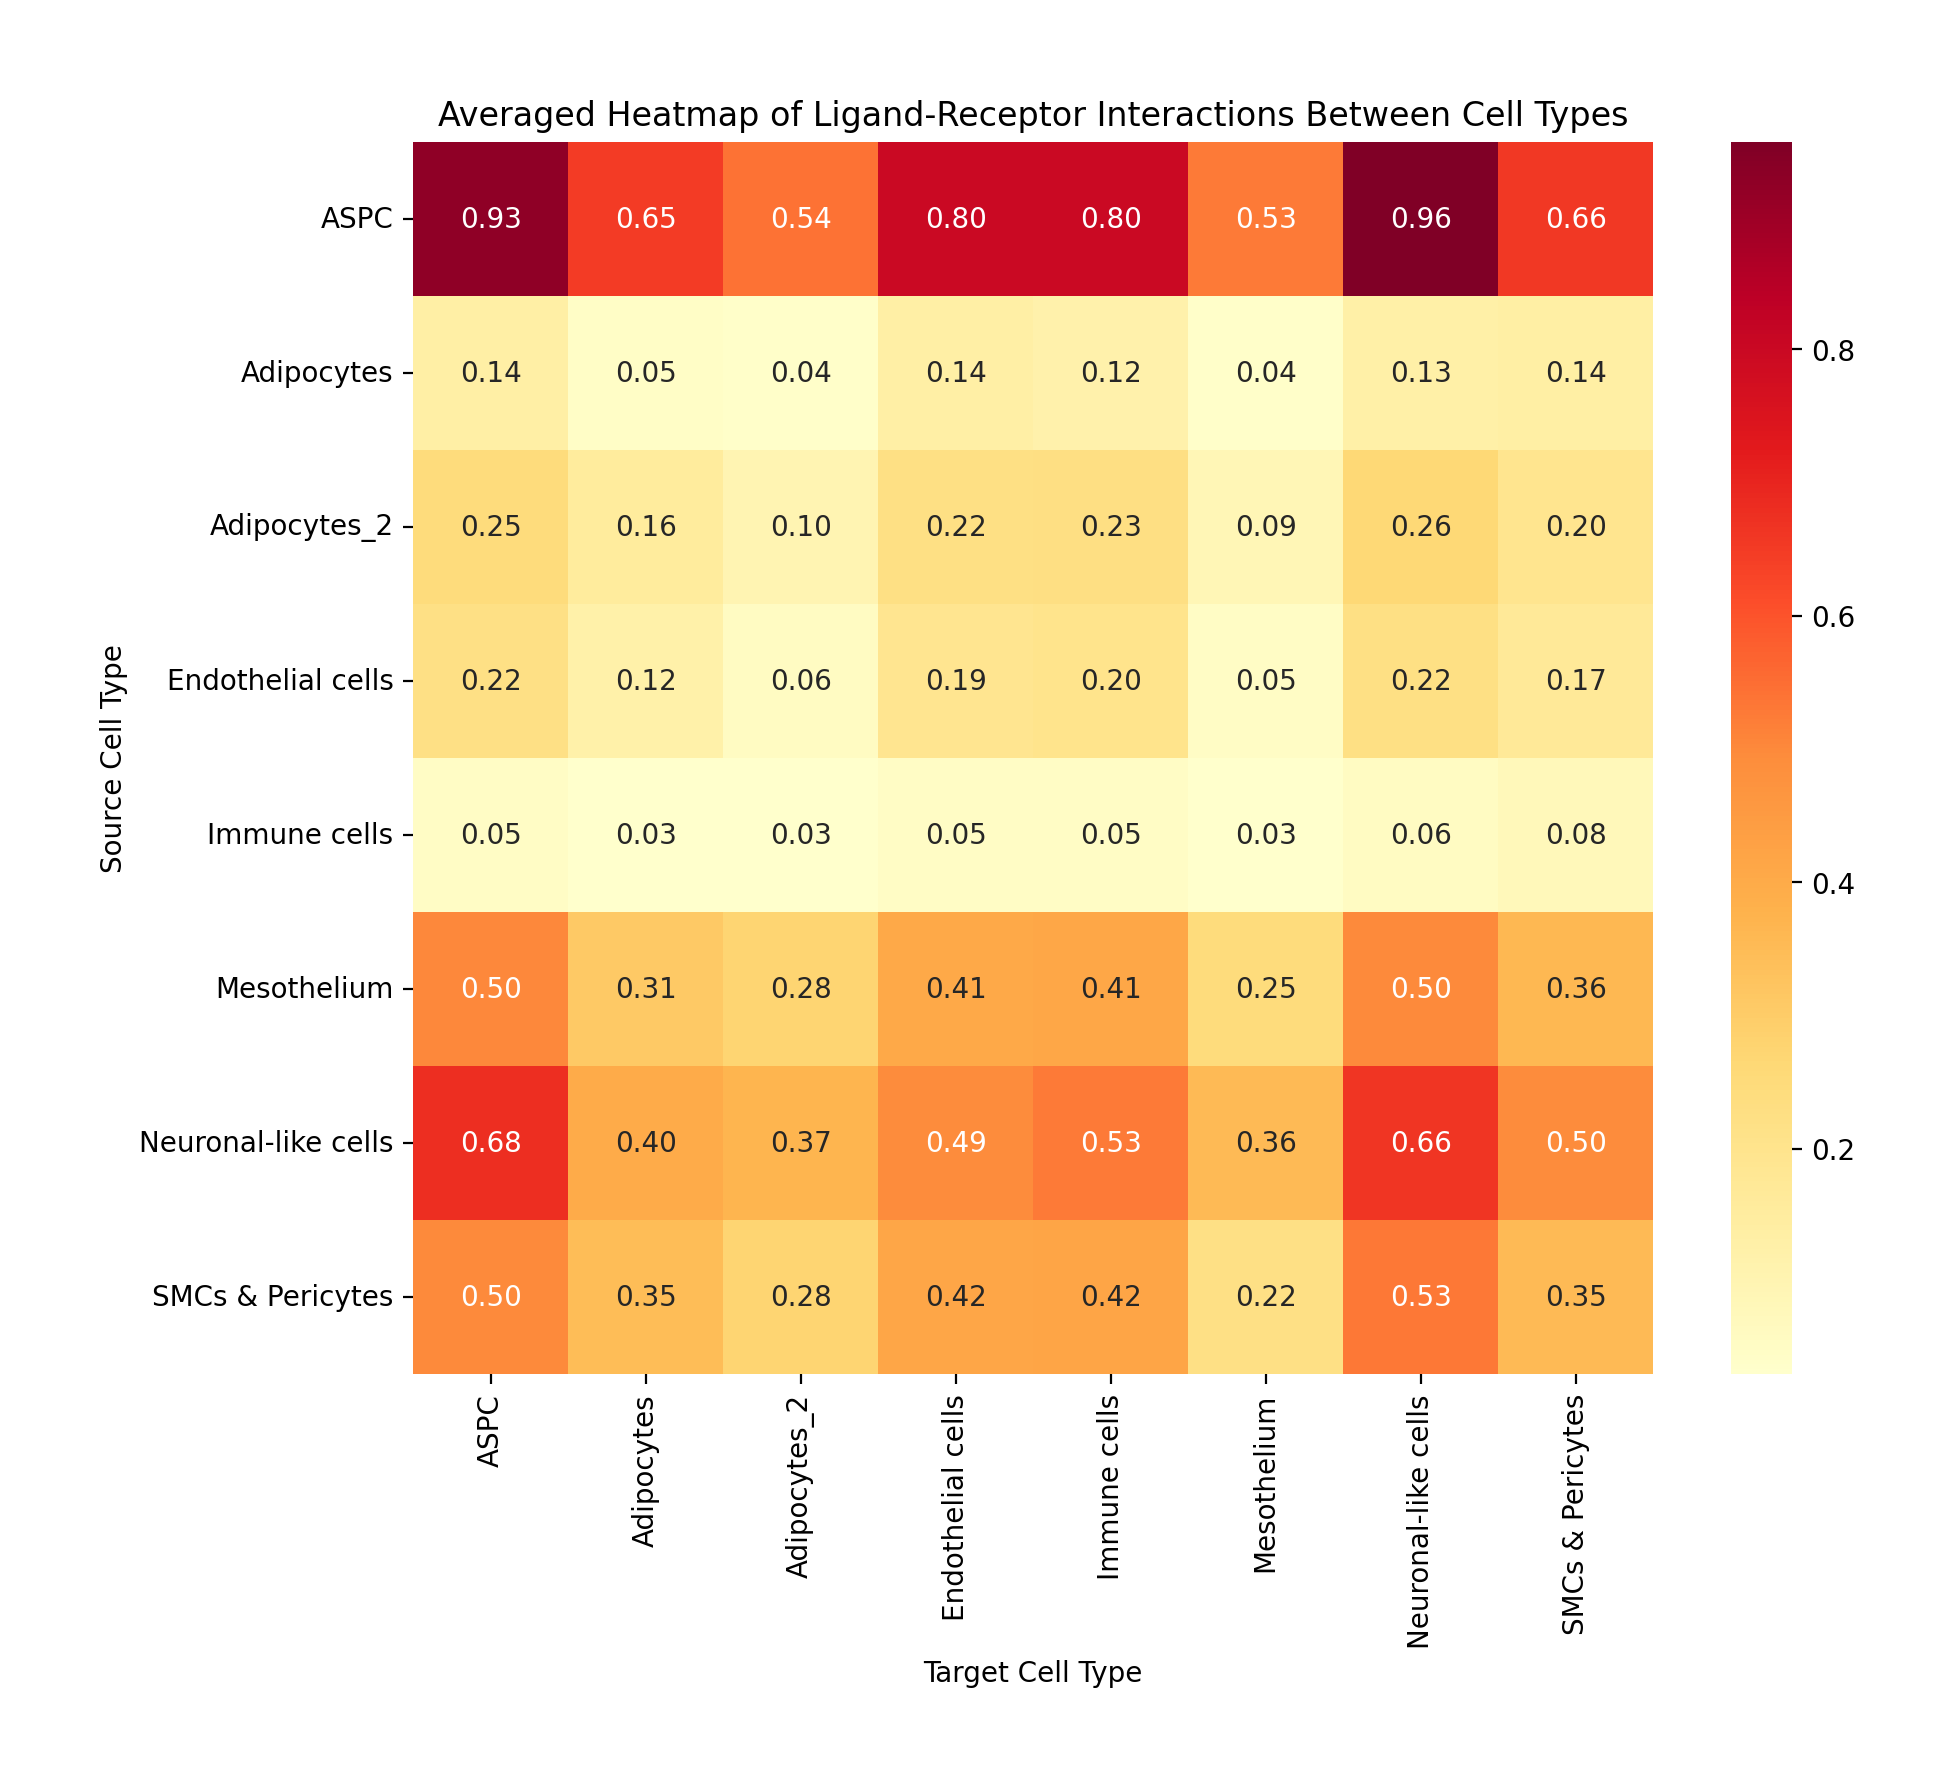

In [38]:
average_interaction_pivot_table = (interaction_pivot_table_cellphonedb + interaction_pivot_table_cellchat + interaction_pivot_table_nichenet) / 3

# Plotting the averaged heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(average_interaction_pivot_table, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Averaged Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()
#fig.savefig("averaged_heatmap.pdf")